# **HMC**

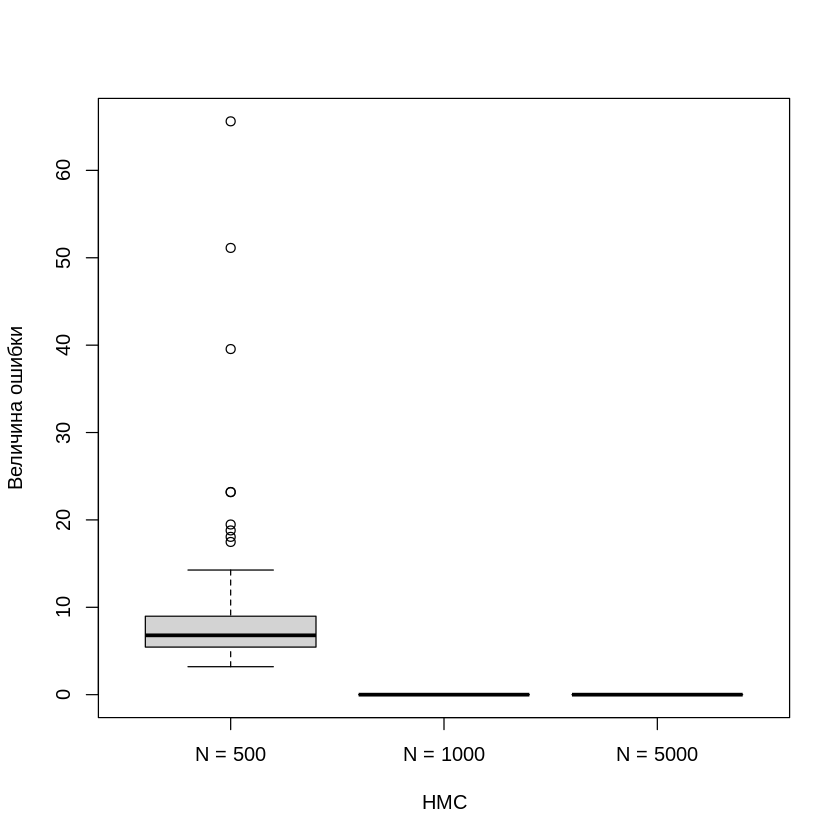

In [ ]:
library("MASS")

d = 2
r = 3
n = 500
M = 100

E = rep(0,M)
Q = matrix(0,M,3)

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

t = 1
epsilon <-0.0017

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)
  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new), lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

for (N in c(50)){
  for(m in 1:M){

    X = matrix(rnorm(d*n),n,d)

    #Параметры
    w_0 = rnorm(1, mu_w_0, sqrt(1/lambda_w_0))
    lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
    mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))
    w = rnorm(d, mu_w, sqrt(1/lambda_w))
    lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
    mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))
    v = matrix(rnorm((d*r), mu_v, sqrt(1/lambda_v)),d,r,byrow=TRUE)

    #Beta_teor
    Beta_teor = c(w_0, w, c(t(v)), lambda_w, mu_w, lambda_v, mu_v)

    sigma2 <- epsilon^2 / (1+d+d*r+2+2*r)^(1 / 3)
    sigma <- sqrt(sigma2)

    doudle_Sum_teor = 0.5 * rowSums((X%*%v)^2 - (X^2)%*%(v^2))
    p = 1 /(1 + exp(-(w_0 + X %*%w + doudle_Sum_teor)))
    y = rbinom(n,1,p)
    j<-0

    mu_w_new = 0
    mu_v_new = rep(0, r)
    lambda_w_new = 1
    lambda_v_new = rep(1, r)

    Theta_0 = 0
    Theta_w = rep(0, d)
    Theta_v = rep(0, d*r)
    Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

    Theta_v_matrix = t(matrix(Theta_v, r, d))

    SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
    S<-diag(1+d+d*r+2+2*r)
    S1 <- solve(S)
    A1 <- chol(S1)

    L =10

    #Логарифм функции правдоподобия для Beta
    loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
    #Логарифм априорного распределения для Theta_H для Beta
    log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
    #Логарифм априорного распределения для Theta для Beta
    log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

    #Логарифм апостериорного распределения для Beta
    logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

    for(i in 1:N){

      P <- c(crossprod(A1, rnorm(1+d+d*r+2+2*r))) # Auxiliary variables
      logK <- c(t(P) %*% S %*% P / 2) # Kinetic energy at the beginning of the trajectory
      Beta_new <-  Beta

      Beta_Theta_0 = Beta_new[1]
      Beta_Theta_w = Beta_new[2:(d+1)]
      Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
      Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

      Beta_lambda_w_new = Beta_new[1+d+d*r+1]
      Beta_mu_w_new = Beta_new[1+d+d*r+2]
      Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
      Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

      #Градиент логарифма апостериорного распределения для Beta_new
      logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                         Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

      Pnew <- P + epsilon/2 * logpost_grad_new

      for (l in 1:L) {
        # Make a full step for the position
        Beta_new <- Beta_new + epsilon * c(S %*% Pnew)
        # Make a full step for the momentum, except at end of trajectory
        if (l != L) Pnew <- Pnew + epsilon * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0,
                                                                    Beta_lambda_w_new, Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda,
                                                                    beta_lambda, gamma_0, mu_0)
      }

      # Make a half step for momentum at the end.
      Pnew <- Pnew + epsilon/2 * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                                        Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

      # Negate momentum at end of trajectory to make the proposal symmetric
      Pnew <- - Pnew

      #Логарифм функции правдоподобия для Beta_new
      loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
      #Логарифм априорного распределения для Theta_H для Beta_new
      log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
      #Логарифм априорного распределения для Theta для Beta_new
      log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

      #Логарифм апостериорного распределения для Beta_new
      logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

      logKnew <- c(t(Pnew) %*% S %*% Pnew / 2)


      # Accept/reject step
      if(runif(1) < exp(logpost_Beta_new - logpost_Beta + logK - logKnew))
      {
        logpost_Beta <- logpost_Beta_new
        Beta <- Beta_new
        j <- j+1
      }
      # Saving results
      SaveResults[i,] <- Beta
    }
    #print(SaveResults)
    b_1 <- colMeans(SaveResults)
    E[m] = sqrt(sum((Beta_teor - b_1)^2))
  }
  Q[,t] = E
  t<-t+1
}
boxplot(Q, names = c("N = 500", "N = 1000", "N = 5000"), ylab = "Величина ошибки", xlab = "HMC")


# **HMC (небольшая размерность)**

In [ ]:
library("MASS")

d = 2
r = 3
n = 500
M = 10

E = rep(0,M)
Q = matrix(0,M,3)

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

t = 1
epsilon <-0.0017

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)
  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new), lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

for (N in c(5)){
  for(m in 1:M){

    X = matrix(rnorm(d*n),n,d)

    #Параметры
    w_0 = rnorm(1, mu_w_0, sqrt(1/lambda_w_0))
    lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
    mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))
    w = rnorm(d, mu_w, sqrt(1/lambda_w))
    lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
    mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))
    v = matrix(rnorm((d*r), mu_v, sqrt(1/lambda_v)),d,r,byrow=TRUE)

    #Beta_teor
    Beta_teor = c(w_0, w, c(t(v)), lambda_w, mu_w, lambda_v, mu_v)

    sigma2 <- epsilon^2 / (1+d+d*r+2+2*r)^(1 / 3)
    sigma <- sqrt(sigma2)

    doudle_Sum_teor = 0.5 * rowSums((X%*%v)^2 - (X^2)%*%(v^2))
    p = 1 /(1 + exp(-(w_0 + X %*%w + doudle_Sum_teor)))
    y = rbinom(n,1,p)
    j<-0

    mu_w_new = 0
    mu_v_new = rep(0, r)
    lambda_w_new = 1
    lambda_v_new = rep(1, r)

    Theta_0 = 0
    Theta_w = rep(0, d)
    Theta_v = rep(0, d*r)
    Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

    Theta_v_matrix = t(matrix(Theta_v, r, d))

    SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
    S<-diag(1+d+d*r+2+2*r)
    S1 <- solve(S)
    A1 <- chol(S1)

    L =10

    #Логарифм функции правдоподобия для Beta
    loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
    #Логарифм априорного распределения для Theta_H для Beta
    log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
    #Логарифм априорного распределения для Theta для Beta
    log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

    #Логарифм апостериорного распределения для Beta
    logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

    for(i in 1:N){

      P <- c(crossprod(A1, rnorm(1+d+d*r+2+2*r))) # Auxiliary variables
      logK <- c(t(P) %*% S %*% P / 2) # Kinetic energy at the beginning of the trajectory
      Beta_new <-  Beta

      Beta_Theta_0 = Beta_new[1]
      Beta_Theta_w = Beta_new[2:(d+1)]
      Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
      Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

      Beta_lambda_w_new = Beta_new[1+d+d*r+1]
      Beta_mu_w_new = Beta_new[1+d+d*r+2]
      Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
      Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

      #Градиент логарифма апостериорного распределения для Beta_new
      logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                         Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

      Pnew <- P + epsilon/2 * logpost_grad_new

      for (l in 1:L) {
        # Make a full step for the position
        Beta_new <- Beta_new + epsilon * c(S %*% Pnew)
        # Make a full step for the momentum, except at end of trajectory
        if (l != L) Pnew <- Pnew + epsilon * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0,
                                                                    Beta_lambda_w_new, Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda,
                                                                    beta_lambda, gamma_0, mu_0)
      }

      # Make a half step for momentum at the end.
      Pnew <- Pnew + epsilon/2 * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                                        Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

      # Negate momentum at end of trajectory to make the proposal symmetric
      Pnew <- - Pnew

      #Логарифм функции правдоподобия для Beta_new
      loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
      #Логарифм априорного распределения для Theta_H для Beta_new
      log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
      #Логарифм априорного распределения для Theta для Beta_new
      log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

      #Логарифм апостериорного распределения для Beta_new
      logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

      logKnew <- c(t(Pnew) %*% S %*% Pnew / 2)


      # Accept/reject step
      if(runif(1) < exp(logpost_Beta_new - logpost_Beta + logK - logKnew))
      {
        logpost_Beta <- logpost_Beta_new
        Beta <- Beta_new
        j <- j+1
      }
      # Saving results
      SaveResults[i,] <- Beta
    }
    #print(SaveResults)
    b_1 <- colMeans(SaveResults)
    E[m] = sqrt(sum((Beta_teor - b_1)^2))
  }
  Q[,t] = E
  t<-t+1
}
SaveResults
cat("Среднее по матрице", b_1, "\n")

0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0


Среднее по матрице 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 


# **Datasets**

In [ ]:
install.packages("PRROC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**Pima Indians Diabetes Dataset**

6,148,72,35,0,33.6,0.627,50,1
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31.0,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1
8,125,96,0,0,0.0,0.232,54,1


[1] 0.5733008

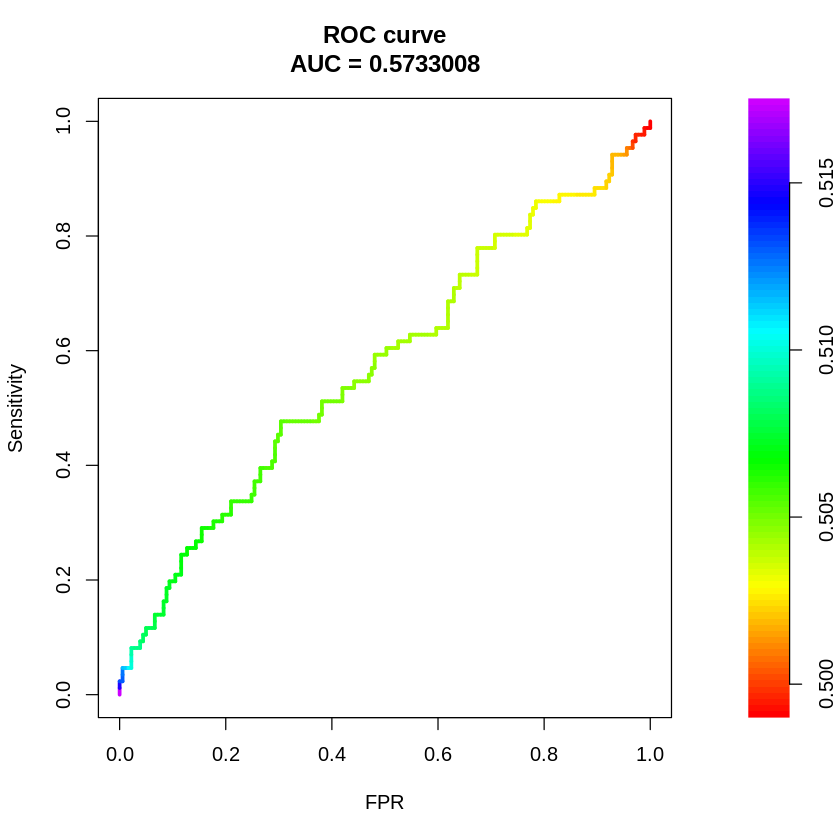

In [ ]:
library("MASS")
library("PRROC")
library(data.table)


data <- fread("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", header=TRUE)
data
data = as.matrix(data)

X = data[1:500,1:8]
y = data[1:500,9]

d = ncol(X)
n = 500
r = 3
N = 100

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

epsilon <-0.00006

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
S<-diag(1+d+d*r+2+2*r)
S1 <- solve(S)
A1 <- chol(S1)

L =10

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)
  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w_new*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new), lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){

  P <- c(crossprod(A1, rnorm(1+d+d*r+2+2*r))) # Auxiliary variables
  logK <- c(t(P) %*% S %*% P / 2) # Kinetic energy at the beginning of the trajectory
  Beta_new <-  Beta

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_lambda_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_w_new = Beta_new[1+d+d*r+2]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

  #Градиент логарифма апостериорного распределения для Beta_new
  logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                      Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  Pnew <- P + epsilon/2 * logpost_grad_new

  for (l in 1:L) {
    # Make a full step for the position
    Beta_new <- Beta_new + epsilon * c(S %*% Pnew)
    # Make a full step for the momentum, except at end of trajectory
    if (l != L) Pnew <- Pnew + epsilon * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0,
                                                                Beta_lambda_w_new, Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda,
                                                                beta_lambda, gamma_0, mu_0)
  }

  # Make a half step for momentum at the end.
  Pnew <- Pnew + epsilon/2 * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                                    Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  # Negate momentum at end of trajectory to make the proposal symmetric
  Pnew <- - Pnew

  #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

  logKnew <- c(t(Pnew) %*% S %*% Pnew / 2)

  # Accept/reject step
  if(runif(1) < exp(logpost_Beta_new - logpost_Beta + logK - logKnew))
  {
    logpost_Beta <- logpost_Beta_new
    Beta <- Beta_new
  }
  # Saving results
  SaveResults[i,] <- Beta
}

b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[501:767,1:8]
y1 = data[501:767,9]
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)


**Sonar Dataset**

[1] 0.6218085

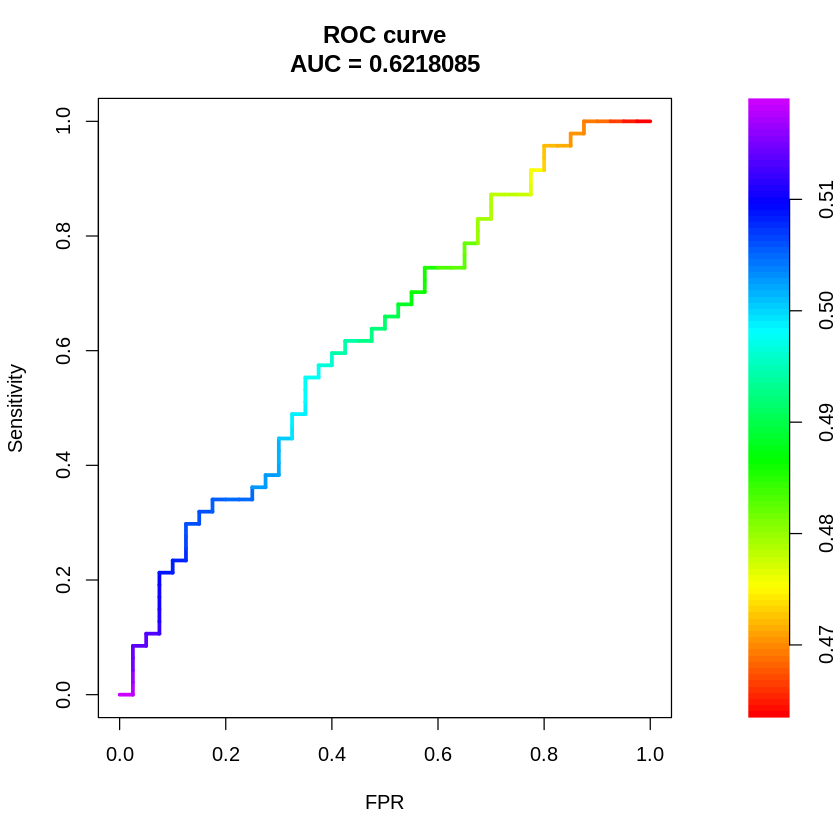

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data = fread("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=TRUE)
ind = sample(1:207)
data = data[ind,]

n = 120
r = 2
N = 100

X = data[1:n,1:60]
X = as.matrix(X)

y = (data[1:n,61]=='R') *1
y <- as.vector(y)

d = ncol(X)

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

epsilon <-0.001

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
S<-diag(1+d+d*r+2+2*r)
S1 <- solve(S)
A1 <- chol(S1)

L =10

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)
  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w_new*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new), lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){

  P <- c(crossprod(A1, rnorm(1+d+d*r+2+2*r))) # Auxiliary variables
  logK <- c(t(P) %*% S %*% P / 2) # Kinetic energy at the beginning of the trajectory
  Beta_new <-  Beta

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_lambda_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_w_new = Beta_new[1+d+d*r+2]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

  #Градиент логарифма апостериорного распределения для Beta_new
  logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                      Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  Pnew <- P + epsilon/2 * logpost_grad_new

  for (l in 1:L) {
    # Make a full step for the position
    Beta_new <- Beta_new + epsilon * c(S %*% Pnew)
    # Make a full step for the momentum, except at end of trajectory
    if (l != L) Pnew <- Pnew + epsilon * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0,
                                                                Beta_lambda_w_new, Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda,
                                                                beta_lambda, gamma_0, mu_0)
  }

  # Make a half step for momentum at the end.
  Pnew <- Pnew + epsilon/2 * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                                    Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  # Negate momentum at end of trajectory to make the proposal symmetric
  Pnew <- - Pnew

  #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

  logKnew <- c(t(Pnew) %*% S %*% Pnew / 2)

  # Accept/reject step
  if(runif(1) < exp(logpost_Beta_new - logpost_Beta + logK - logKnew))
  {
    logpost_Beta <- logpost_Beta_new
    Beta <- Beta_new

  }
  # Saving results
  SaveResults[i,] <- Beta
}

b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[121:207,1:60]
X1 =as.matrix(X1)
y1 = (data[121:207,61]=='R')*1

D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Australian Credit Approval DataSet**

[1] 0.6655117

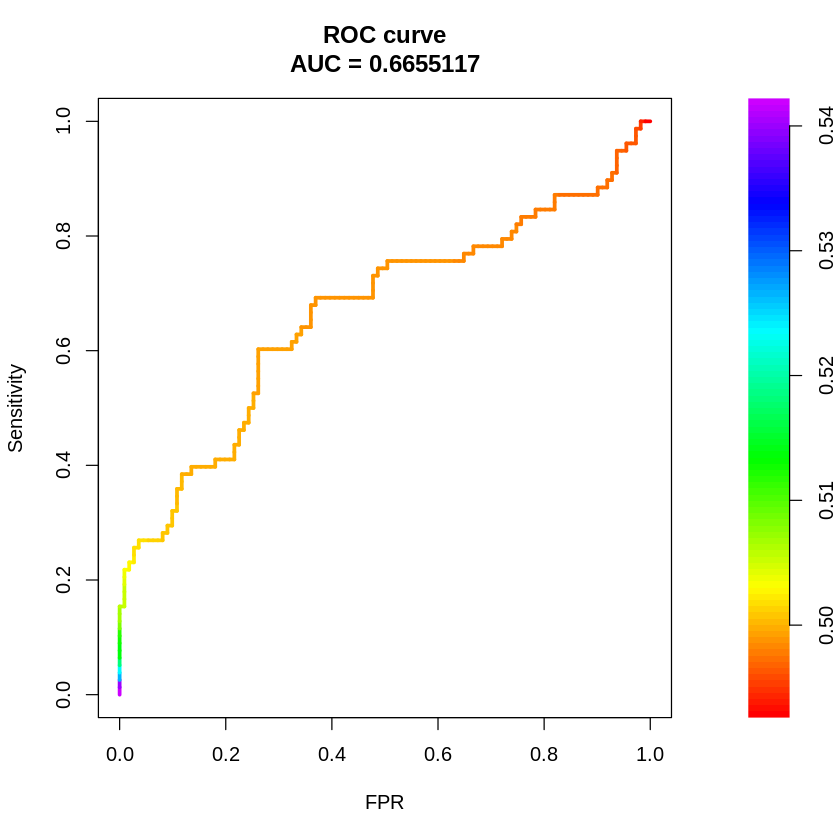

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data = fread("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat", header = TRUE)
data = as.matrix(na.omit(data))

n = 500
y = data[1:n,15]
X = data[1:n,1:14]

d = ncol(X)

r = 3
N = 100

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

epsilon <-0.000001

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
S<-diag(1+d+d*r+2+2*r)
S1 <- solve(S)
A1 <- chol(S1)

L =10

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)
  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w_new*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new), lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){

  P <- c(crossprod(A1, rnorm(1+d+d*r+2+2*r))) # Auxiliary variables
  logK <- c(t(P) %*% S %*% P / 2) # Kinetic energy at the beginning of the trajectory
  Beta_new <-  Beta

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_lambda_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_w_new = Beta_new[1+d+d*r+2]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

  #Градиент логарифма апостериорного распределения для Beta_new
  logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                      Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  Pnew <- P + epsilon/2 * logpost_grad_new

  for (l in 1:L) {
    # Make a full step for the position
    Beta_new <- Beta_new + epsilon * c(S %*% Pnew)
    # Make a full step for the momentum, except at end of trajectory
    if (l != L) Pnew <- Pnew + epsilon * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0,
                                                                Beta_lambda_w_new, Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda,
                                                                beta_lambda, gamma_0, mu_0)
  }

  # Make a half step for momentum at the end.
  Pnew <- Pnew + epsilon/2 * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                                    Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  # Negate momentum at end of trajectory to make the proposal symmetric
  Pnew <- - Pnew

  #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

  logKnew <- c(t(Pnew) %*% S %*% Pnew / 2)

  # Accept/reject step
  if(runif(1) < exp(logpost_Beta_new - logpost_Beta + logK - logKnew))
  {
    logpost_Beta <- logpost_Beta_new
    Beta <- Beta_new

  }
  # Saving results
  SaveResults[i,] <- Beta
}

b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[501:689,1:14]
y1 = data[501:689,15]

D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Banknote Dataset**

[1] 0.8055899

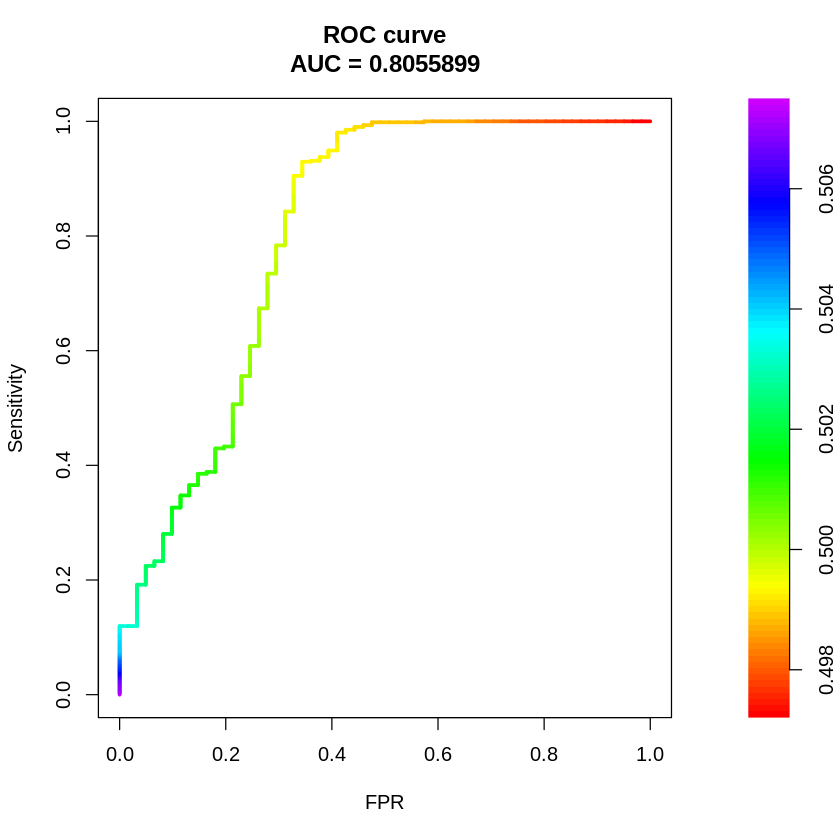

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data <- fread("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", header = TRUE)
data = as.matrix(data)
X = data[1:700,1:4]
y = data[1:700,5]


d = ncol(X)
n = 700
r = 2
N = 100


#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

epsilon <-0.0001

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

SaveResults<- matrix(0,N,1+d+d*r+2+2*r)
S<-diag(1+d+d*r+2+2*r)
S1 <- solve(S)
A1 <- chol(S1)

L =10

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

#Функция: градиент логарифма апостериорного распределения
logpost_grad_function <- function(X,Theta_0, Theta_w, Theta_v_matrix, y, lambda_w_0, mu_w_0, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new,
                                  alpha_lambda, beta_lambda, gamma_0, mu_0){

  doudle_Sum = 0.5 * rowSums((X%*%Theta_v_matrix)^2 - (X^2)%*%(Theta_v_matrix^2))
  ratioexp_old=c(exp(Theta_0 + X%*%Theta_w+doudle_Sum)/(1+exp(Theta_0 + X%*%Theta_w+doudle_Sum)))

  sums_x <- matrix(apply(X, 2, function(q) apply(X, 2, function(o) sum((y-ratioexp_old)*q*o))), nrow = d, ncol = d)
  v_matrix = c(t(t(crossprod(Theta_v_matrix, sums_x)) - Theta_v_matrix * colSums((y-ratioexp_old)*X^2)))

  h <- matrix(c(rep(1, n), X), n, 1 + d)
  h_sum = colSums((y-ratioexp_old)*h)

  grad_loglik = c(h_sum, v_matrix, rep(0, 2+2*r))

  grad_log_theta = c(-lambda_w_0*(Theta_0 - mu_w_0), -lambda_w_new*(Theta_w-mu_w_new), -lambda_v_new*(Theta_v_matrix-mu_v_new),
                          -1/2*sum((Theta_w - mu_w_new)^2)+d/(2*lambda_w_new), lambda_w_new*sum(Theta_w - mu_w_new),
                            -1/2*sum((Theta_v_matrix - mu_v_new)^2)+d/(2*lambda_v_new), lambda_v_new*sum(Theta_v_matrix - mu_v_new))

  grad_log_theta_H = c(rep(0, 1+d+d*r), (alpha_lambda-1)/lambda_w_new - beta_lambda + 1/(2*lambda_w_new) - gamma_0/2*(mu_w_new - mu_0)^2,
                               -gamma_0*lambda_w_new*(mu_w_new - mu_0), (alpha_lambda-1)/lambda_v_new - beta_lambda + 1/(2*lambda_v_new) - gamma_0/2*(mu_v_new - mu_0)^2,
                                -gamma_0*lambda_v_new*(mu_v_new - mu_0))

  logpost_grad_new = grad_loglik + grad_log_theta+grad_log_theta_H

  return(logpost_grad_new)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){

  P <- c(crossprod(A1, rnorm(1+d+d*r+2+2*r))) # Auxiliary variables
  logK <- c(t(P) %*% S %*% P / 2) # Kinetic energy at the beginning of the trajectory
  Beta_new <-  Beta

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_lambda_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_w_new = Beta_new[1+d+d*r+2]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3):(1+d+d*r+2+r)]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2+r+1):(1+d+d*r+2+2*r)]

  #Градиент логарифма апостериорного распределения для Beta_new
  logpost_grad_new = logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                      Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  Pnew <- P + epsilon/2 * logpost_grad_new

  for (l in 1:L) {
    # Make a full step for the position
    Beta_new <- Beta_new + epsilon * c(S %*% Pnew)
    # Make a full step for the momentum, except at end of trajectory
    if (l != L) Pnew <- Pnew + epsilon * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0,
                                                                Beta_lambda_w_new, Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda,
                                                                beta_lambda, gamma_0, mu_0)
  }

  # Make a half step for momentum at the end.
  Pnew <- Pnew + epsilon/2 * logpost_grad_function(X, Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, lambda_w_0, mu_w_0, Beta_lambda_w_new,
                                                    Beta_mu_w_new, Beta_lambda_v_new, Beta_mu_v_new, alpha_lambda, beta_lambda, gamma_0, mu_0)

  # Negate momentum at end of trajectory to make the proposal symmetric
  Pnew <- - Pnew

  #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

  logKnew <- c(t(Pnew) %*% S %*% Pnew / 2)

  # Accept/reject step
  if(runif(1) < exp(logpost_Beta_new - logpost_Beta + logK - logKnew))
  {
    logpost_Beta <- logpost_Beta_new
    Beta <- Beta_new

  }
  # Saving results
  SaveResults[i,] <- Beta
}
b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[701:1371,1:4]
y1 = data[701:1371,5]

D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)